## Related Python projects

- [a Kaggle notebook using BigQuery](https://www.kaggle.com/paultimothymooney/how-to-query-the-noaa-ghcn-daily-weather-data)
- [Get_NOAA_GHCN_data](https://github.com/aaronpenne/get_noaa_ghcn_data) - a python3 library to make it easier to access GHCN data

## Sources for historical weather data

- [weather underground](https://www.wunderground.com/history/daily/KRIC/date/2021-1-23) - private, ad supported - not intended for bulk download
- [national weather service](https://w2.weather.gov/climate/local_data.php?wfo=akq) - mostly aggregate PDFs
- [national climate data center](https://www.ncdc.noaa.gov/cdo-web/) - prominently offers paid access
    - [NCDC 2](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00013740/detail) - RIC station
- [NCEI](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00861/html) - very helpful dataset resource - provided NCDC GCHN public links

For one station, download from e.g. https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/USW00013740.dly
where in this case, Richmond International Airport has code 'USW00013740'

Station codes can be found in https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt

In [16]:
import pandas as pd
import numpy as np
import requests
import urllib.request
import os
from io import StringIO

In [ ]:
station_id = 'USW00013740'
output_dir = 'ghcn_data'
os.environ["DLY_OUTPUT"] = output_dir

# download the daily file
#urllib.request.urlretrieve(f'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{station_id}.dly', f'{output_dir}/{station_id}.dly')


In [22]:
# from https://github.com/aaronpenne/get_noaa_ghcn_data
import get_dly 
#station_id = 'USW00013740'
ftp = get_dly.connect_to_ftp()
get_dly.dly_to_csv(ftp, station_id)
ftp.quit()

230-****** WARNING ** WARNING ** WARNING ** WARNING ** WARNING ** ** WARNING ** WARNING ** WARNING ******
 ** You are accessing a U.S. Government information system, which includes:                         **
 ** 1) This computer, 2)This computer network, 3) All computers connected to this network, and      **
 ** 4) All devices and storage media attached to this network or to a computer on this network.     **
 ** You understand and consent to the following:                                                    **
 ** you may access this information system for authorized use only; you have no reasonable          **
 ** expectation of privacy regarding any communication of data transiting or stored on this         **
 ** information system; at any time and for any lawful Government purpose, the Government may       **
 ** monitor, intercept, and search and seize any communication or data transiting or stored on      **
 ** this information system; and any communications or data transiting

'221 Goodbye.'

In [57]:
ric = pd.read_csv(station_id + '.csv')

/home/kfinity/anaconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (14,24,26,48,50,52,56,58,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [58]:
# drop columns
ric = ric.loc[:,['MM/DD/YYYY','YEAR','MONTH','TMIN','TMAX']]

# fix date column
ric['DAY'] = pd.to_datetime(ric['MM/DD/YYYY'], format='%Y-%m-%d')

#ric.set_index('DAY', inplace=True)

In [62]:
# convert TMIN from "tenths of degrees C" to F
ric['TMIN_F'] = (ric['TMIN'] /10 * 9/5) +32

In [118]:
# first-last df
# max date in first half of year with frost (last frost date)
fl = ric.loc[(ric['MONTH']<7) & (ric['TMIN_F']<=32.0),:].groupby('YEAR').agg({'DAY': 'max'}).reset_index()
fl['LAST'] = pd.to_numeric(fl['DAY'].apply(lambda d: d.strftime('%j')))

In [127]:
# min date in second half of year with frost
fl['FIRST'] = pd.to_numeric(ric.loc[(ric['MONTH']>6) & (ric['TMIN_F']<=32.0), :]\
                            .groupby('YEAR').agg({'DAY': 'min'}).reset_index()['DAY']\
                            .apply(lambda d: d.strftime('%j')))
fl = fl.dropna() # probably drops the current year, if it doesn't have a first fall frost date yet.
fl['FIRST'] = fl['FIRST'].astype('int16')

In [167]:
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# convert day of year to month-day string labels
def j_to_md(x, pos):
    return datetime.strptime(str(int(x)), '%j').strftime('%b %d')
    
jmd_formatter = FuncFormatter(j_to_md)

In [41]:
import seaborn as sns

In [134]:
#sns.scatterplot(data=fl, x="YEAR", y="LAST")

In [133]:
#sns.scatterplot(data=fl, x="YEAR", y="LAST")

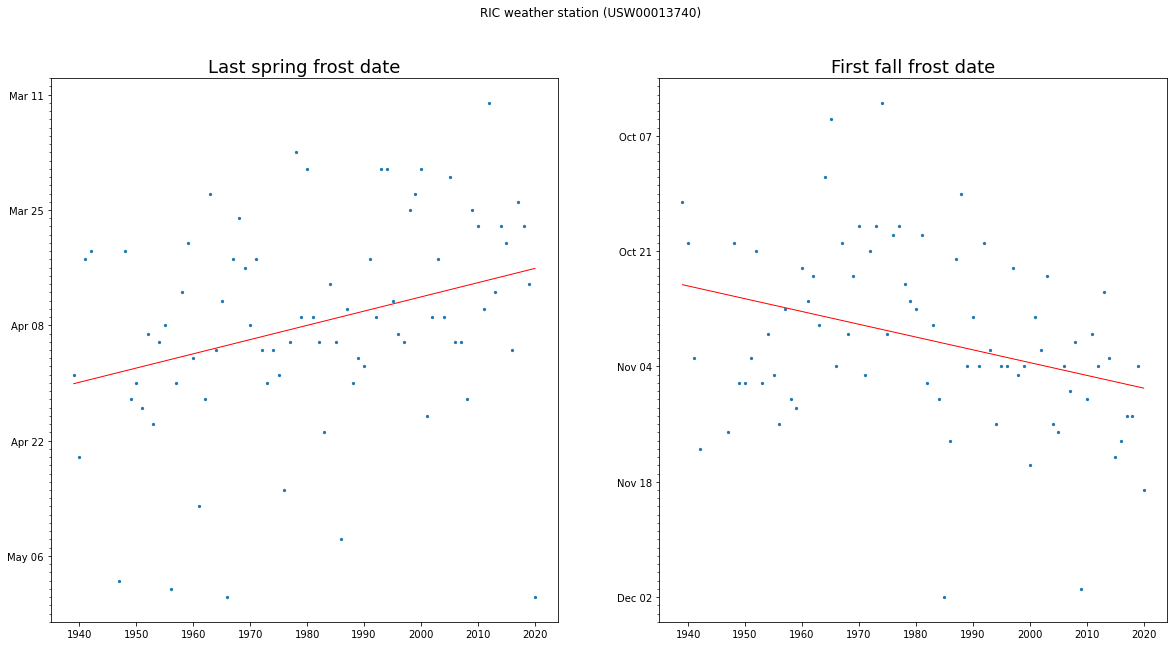

Average last frost date:
1939: Apr 15
2020: Apr 01
2020 actual last frost date: May 11
Average first frost date:
1939: Oct 25
2020: Nov 06
2020 actual first frost date: Nov 19


In [185]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

# 2 plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# set figure size in inches
fig.set_figheight(10)
fig.set_figwidth(20)

ax1.scatter(fl.YEAR, fl.LAST, s=5)

z = np.polyfit(fl.YEAR, fl.LAST, 1)
p = np.poly1d(z)
ax1.plot(fl.YEAR, p(fl.YEAR), "r", linewidth=1)

ax1.yaxis.set_major_locator(MultipleLocator(14))
ax1.yaxis.set_major_formatter(jmd_formatter)
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.invert_yaxis()

ax1.set_title('Last spring frost date', fontsize=18)

# first frost
ax2.scatter(fl.YEAR, fl.FIRST, s=5)

z2 = np.polyfit(fl.YEAR, fl.FIRST, 1)
p2 = np.poly1d(z2)
ax2.plot(fl.YEAR, p2(fl.YEAR), "r", linewidth=1)

ax2.yaxis.set_major_locator(MultipleLocator(14))
ax2.yaxis.set_major_formatter(jmd_formatter)
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.invert_yaxis()

ax2.set_title('First fall frost date', fontsize=18)

fig.suptitle('RIC weather station (USW00013740)', fontsize=12)

plt.show()

print('Average last frost date:')
print('1939: {}'.format(jmd_formatter(p(1939),0)))
print('2020: {}'.format(jmd_formatter(p(2020),0)))
print('2020 actual last frost date: {}'.format(jmd_formatter(fl.loc[fl['YEAR']==2020,'LAST'],0)))
print('Average first frost date:')
print('1939: {}'.format(jmd_formatter(p2(1939),0)))
print('2020: {}'.format(jmd_formatter(p2(2020),0)))
print('2020 actual first frost date: {}'.format(jmd_formatter(fl.loc[fl['YEAR']==2020,'FIRST'],0)))


In [186]:
fig.savefig("ric_frosts.png", facecolor='white', bbox_inches='tight') # tight margins

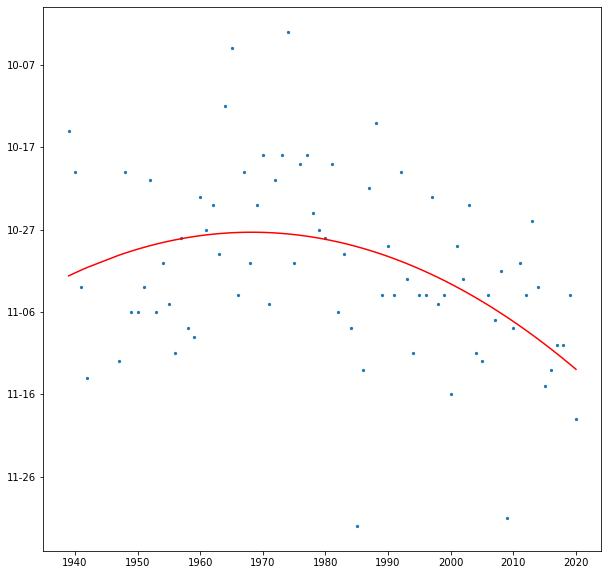

Average first frost date:
1939: 11-01
2020: 11-12
2020 actual first frost date: 11-19


In [165]:
# set figure size in inches
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

plt.scatter(fl.YEAR, fl.FIRST, s=5)

z2 = np.polyfit(fl.YEAR, fl.FIRST, 2)
p2 = np.poly1d(z2)
plt.plot(fl.YEAR, p2(fl.YEAR), "r")

ax.yaxis.set_major_formatter(jmd_formatter)
plt.gca().invert_yaxis()

plt.show()
print('Average first frost date:')
print('1939: {}'.format(jmd_formatter(p2(1939),0)))
print('2020: {}'.format(jmd_formatter(p2(2020),0)))
print('2020 actual first frost date: {}'.format(jmd_formatter(fl.loc[fl['YEAR']==2020,'FIRST'],0)))


### Statistical analysis

In [187]:
os.path.relpath('output')

'output'